In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, f1_score
import math
from tqdm import tqdm


from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors

In [ ]:
# convert data to a normalized torch.FloatTensor
# transform = transforms.Compose([    transforms.ToTensor(), transforms.Normalize(
#         mean=[0.4914, 0.4822, 0.4465],
#         std=[0.2023, 0.1994, 0.2010])
# ])

transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

In [ ]:
# loading the train data
batch_size = 1000
#drop_last=True
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True )

#loading the test data
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
test_dataloader = DataLoader(test_data,batch_size=batch_size, shuffle=True)
# You should define x_train and y_train

In [ ]:
feature_extractor = resnet34(pretrained=True)
num_features = feature_extractor.fc.in_features

for param in feature_extractor.parameters():
    param.requires_grad = False

feature_extractor.fc = nn.Identity()
# feature_extractor.to(device)

In [ ]:

# Helper functions

# Data Normalisation
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

# Euclidean distance
def e_distance(x,y):
  return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
  return distance.cityblock(x,y)

# Best Matching Unit search
def winning_neuron(data, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = 10e7 # initialise with max distance
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data)
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col]
  return winner

# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  # neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate

def dist_func(x):
  #guassian
  sig = 2 #?
  return np.exp(-np.power(x , 2.) / (2 * np.power(sig, 2.)))
  

In [ ]:
y_data_list = []
data_list = []
for x_train, y_train in train_dataloader:

  features = feature_extractor(x_train)
  features = minmax_scaler(features)
  features = torch.from_numpy(features)
  data_list.append(features)

  y_data_list.append(y_train)

print(len(y_data_list))
print(len(data_list))

In [ ]:
y_test_list = []
data_test_list = []
for x_test, y_test in test_dataloader:

  features = feature_extractor(x_test)
  features = minmax_scaler(features)
  features = torch.from_numpy(features)
  data_test_list.append(features)

  y_test_list.append(y_test)

print(len(y_test_list))
print(len(data_test_list))

In [ ]:
# hyperparameters
num_rows = 10
num_cols = 10
max_m_dsitance = 3
max_learning_rate = 0.5
# max_steps = int(7.5*10e3)
max_steps = 20


# num_nurons = 5*np.sqrt(train_x.shape[0])
# grid_size = ceil(np.sqrt(num_nurons))
# print(grid_size)

In [ ]:
# train_x_norm = minmax_scaler(train_x) # normalisation

# num_dims = train_x_norm.shape[1]


# initialising self-organising map
num_dims = 512 # numnber of dimensions in the input data

np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction
som = torch.from_numpy(som)

In [ ]:
epochs = 1

for epoch in range(epochs):
    for features in tqdm(data_list, desc=f"Epoch {epoch+1}", colour="blue"):
            # Forward pass

            # features = feature_extractor(x_train)
            # features = minmax_scaler(features)
            # features = torch.from_numpy(features)



            # start training iterations
            for i in range(features.shape[0]):
              neighbourhood_range = max_m_dsitance
              learning_rate = decay(epoch, epochs, max_learning_rate, max_m_dsitance)

              # rand_data = np.random.randint(0,high=features.shape[0]) # random index of traing data
              winner = winning_neuron(features[i], som, num_rows, num_cols)
              for row in range(num_rows):
                for col in range(num_cols):
                  dist = m_distance([row,col],winner)
                  if dist <= neighbourhood_range:
                    som[row][col] += learning_rate * dist_func(dist) * (features[i]-som[row][col]) #update neighbour's weight

            # print("SOM training completed")

In [ ]:
# collecting labels
map = np.empty(shape=(num_rows, num_cols), dtype=object)
for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for i, features in enumerate(data_list):


  # features = feature_extractor(x_train)
  # features = minmax_scaler(features)
  # features = torch.from_numpy(features)
  label_data = np.array(y_data_list[i])
  
  
  for t in range(features.shape[0]):
    winner = winning_neuron(features[t], som, num_rows, num_cols)
    map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

In [ ]:
print(np.array(y_data_list[0]))
print(map[0][0])

In [ ]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 11
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label


In [ ]:
# title = ('Iteration ' + str(max_steps))
# cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(label_map, cmap='Blues')
plt.colorbar()
# plt.title(title)
plt.show()

In [ ]:

# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node
# x_test, y_test = test_dataloader
sum_acc = 0
n = 0
for i, features in enumerate(data_test_list):


  # features = feature_extractor(x_test)
  # features = minmax_scaler(features)
  # features = torch.from_numpy(features)
  winner_labels = []

  for t in range(features.shape[0]):
    winner = winning_neuron(features[t], som, num_rows, num_cols)
    row = winner[0]
    col = winner[1]
    predicted = label_map[row][col]
    winner_labels.append(predicted)
  acc = accuracy_score(np.array(y_test_list[i]), np.array(winner_labels))
  sum_acc += acc
  n += 1
  print("Accuracy: ",acc)

print("Total Accuracy: ", sum_acc /n)

In [ ]:

# #mian function

# # start training iterations
# for step in range(max_steps):
#   if (step+1) % 1000 == 0:
#     print("Iteration: ", step+1) # print out the current iteration for every 1k
#   neighbourhood_range = max_m_dsitance
#   learning_rate = decay(step, max_steps,max_learning_rate,max_m_dsitance)

#   t = np.random.randint(0,high=train_x.shape[0]) # random index of traing data
#   winner = winning_neuron(train_x, t, som, num_rows, num_cols)
#   for row in range(num_rows):
#     for col in range(num_cols):
#       if m_distance([row,col],winner)<= neighbourhood_range:
#         som[row][col] += learning_rate*(train_x[t]-som[row][col]) #update neighbour's weight

# print("SOM training completed")

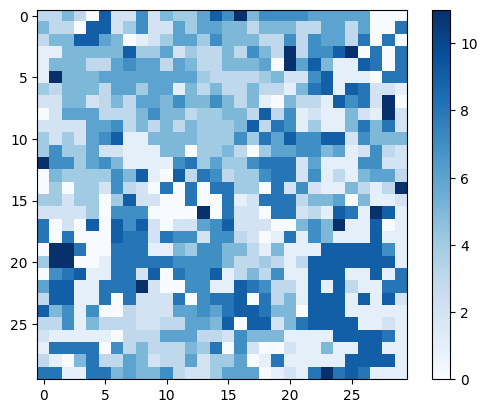

In [49]:
# title = ('Iteration ' + str(max_steps))
# cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(label_map, cmap='Blues')
plt.colorbar()
# plt.title(title)
plt.show()

In [51]:

# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node
# x_test, y_test = test_dataloader
sum_acc = 0
n = 0
for i, features in enumerate(data_test_list):


  # features = feature_extractor(x_test)
  # features = minmax_scaler(features)
  # features = torch.from_numpy(features)
  winner_labels = []

  for t in range(features.shape[0]):
    winner = winning_neuron(features[t], som, num_rows, num_cols)
    row = winner[0]
    col = winner[1]
    predicted = label_map[row][col]
    winner_labels.append(predicted)
  acc = accuracy_score(np.array(y_test_list[i]), np.array(winner_labels))
  sum_acc += acc
  n += 1
  print("Accuracy: ",acc)

print("Total Accuracy: ", sum_acc /n)

Accuracy:  0.227
Accuracy:  0.281
Accuracy:  0.268
Accuracy:  0.279
Accuracy:  0.262
Accuracy:  0.253
Accuracy:  0.265
Accuracy:  0.235
Accuracy:  0.264
Accuracy:  0.268
Total Accuracy:  0.26020000000000004


In [ ]:

# #mian function

# # start training iterations
# for step in range(max_steps):
#   if (step+1) % 1000 == 0:
#     print("Iteration: ", step+1) # print out the current iteration for every 1k
#   neighbourhood_range = max_m_dsitance
#   learning_rate = decay(step, max_steps,max_learning_rate,max_m_dsitance)

#   t = np.random.randint(0,high=train_x.shape[0]) # random index of traing data
#   winner = winning_neuron(train_x, t, som, num_rows, num_cols)
#   for row in range(num_rows):
#     for col in range(num_cols):
#       if m_distance([row,col],winner)<= neighbourhood_range:
#         som[row][col] += learning_rate*(train_x[t]-som[row][col]) #update neighbour's weight

# print("SOM training completed")